# Exercise 8: Supervised Learning

In this exercise a few basic supervised learning pipelines are elaborated.
* Data analysis
* Feature engineering
* Cross-validation
* Regression
  * Linear models and neural networks
* Classification
  * Linear models and gradient boosting machines

Moreover, working with the popular __pandas__ library is presented here.

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
plt.style.use('dark_background')

## Data Set
In this exercise we will use a [data set hosted on Kaggle](https://www.kaggle.com/hankelea/system-identification-of-an-electric-motor).
For ease of use and simplicity, we are going to work on a reduced version though, that is provided with this notebook already.

The data set represents lab measurements from a test bench, where a three-phase electric motor was externally speed-controlled while being induced with different voltages, leading to corresponding currents and, thus, torque on the motor.

### Context
The most important aspect of electric vehicles is their efficiency or achievable range. 
In order to achieve high efficiency, it is essential to avoid the over-dimensioning of the drive train during the design phase.
Therefore, the drive train has to be kept as lightweight as possible while at the same time it should be utilized to its maximum extent. 
This can only be achieved if the dynamic behavior of the drive train is accurately known by the controller/agent. 
The task of the controller is to achieve a desired torque at the wheels of the car by controlling the currents of the electric motor.

Control, in this context, is about choosing appropriate, discrete switching states for the transistors in the attached power electronic unit, that affect the voltage applied to the motor.
Knowing which switching state leads to what current change at each point in time helps the controller to choose an appropriate action.
Since in the real world many parasitic, intangible and volatile effects are imposed on currents formation, modeling them statistically is an auspicious endeavor.

### Features

Most of the time, a data set is a table/matrix/2d-tensor with labeled columns (and rows).

Here, rows are consecutively enumerated while columns are the following:

* __n_1k__: elementary vector applied between (k-1) and k. The elementary vector denotes the label-encoded switching state in the converter.
* __id_k__: d-current at k in A (Ampere).
* __iq_k__: q-current at k in A (Ampere). 
* __epsilon_k__: rotor angle at k in rad (Radian).
* __n_k__: elementary vector applied between k and (k+1). 
* __id_k1__: d-current at (k+1) in A (Ampere).
* __iq_k1__: q-current at (k+1) in A (Ampere).

[Read up on d/q-transformation](https://en.wikipedia.org/wiki/Direct-quadrature-zero_transformation) to understand the coordinate notation of the currents (assuming the amplitude-invariant transformation than the power-invariant).

The enlisted features will be utilized for either regression or classification.
Depending on the task, the features denoting input and target quantities will vary, such that the specific mapping will be discussed later.

Lab measurements from a motor are commonly time series data.
Yet, here the records are shuffled, and we only have the link between two elementary vectors (switching states/ actions) in a row itself.

### Optional Literature
If you find the following exercise intriguing and you would like to keep on investigating, have a look at the scientific papers that describe the background to the underlying data set:
* [Part 1](https://arxiv.org/pdf/2003.07273.pdf)
* [Part 2](https://arxiv.org/pdf/2003.06268.pdf)

### Load CSV data set

In [2]:
df = pd.read_csv('reduced_emotor.csv')
print(df.shape)
df.head()

(2450000, 7)


,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1
0,-63.43288,222.963500,-1.624982,1,1,-52.36959,217.568600
1,-138.64790,164.999000,-0.499233,1,1,-126.95130,163.001400
2,-162.46010,38.855290,-2.065194,1,1,-156.43410,38.598410
3,-219.68470,0.211794,-2.266253,1,1,-218.79350,0.402872
4,-86.63434,160.142600,-3.091227,1,1,-75.96732,157.305300


The pandas library makes reading csv files easy, next to its superb data wrangling utilities. 

Think of pandas as a layer on top of numpy, that is optimized for tabular data and attaches column/row names to a matrix.

The main pandas class is the so-called _DataFrame_ which holds a table, and the _Series_  that denotes a single column.
Both classes do not only consist of arrays representing the data itself but also of an index (row labeling), that affects basic arithmetic operations between different instantiated objects.

Please refer to the pandas notebooks from exercise 1 for a refresher.

### Adding new features
There are two main ways to add further features to the dataframe.

In [3]:
# new feature "pairs"
df = df.assign(pairs=lambda r: r.n_1k.astype(str)+'->'+r.n_k.astype(str))
# alternatively
df['pairs_alternative'] = df.n_1k.astype(str) + '->' + df.n_k.astype(str) 

assert all(df.pairs == df.pairs_alternative)
# remove a feature
del df['pairs_alternative']
# alternatively
# df = df.drop(['pairs_alternative'], axis=1)

In [4]:
df.columns

Index(['id_k', 'iq_k', 'epsilon_k', 'n_k', 'n_1k', 'id_k1', 'iq_k1', 'pairs'], dtype='object')

In [5]:
df.pairs.value_counts().sort_index().head(10)

1->1    50000
1->2    50000
1->3    50000
1->4    50000
1->5    50000
1->6    50000
1->7    50000
2->1    50000
2->2    50000
2->3    50000
Name: pairs, dtype: int64

We recognize, that all transitions within a row appear uniformly throughout the dataset, which is not the case for the original kaggle data but has been intentionally rectified for this exercise's reduced version.

## Exploratory Data Analysis
Before any feature engineering should be conducted, it is advisable to investigate the general structure of the data.

This process is called exploratory data analysis (EDA) and usually comprises 
* distribution visualizations, 
* missing data detection, 
* substitution of such, 
* linear correlation analysis,
* time series analysis
* etc.

### Distribution visualizations

In [6]:
def plot_dist(_df):
    fig, axes = plt.subplots(1,2,sharex=True, sharey=True)
    for c, ax in zip(['n_k', 'n_1k'], axes.flatten()):
        sns.countplot(x=c, data=_df,  ax=ax)

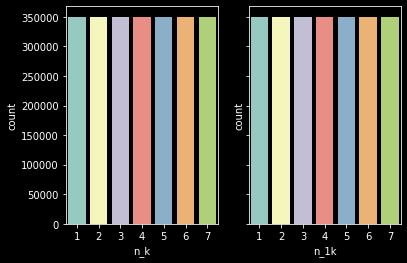

In [7]:
plot_dist(df)

Each elementary vector occurs around 350 thousand times for both, at time _k_ and time _k-1_ .

In the following we plot the distribution of the currents and the motor angle unfolded over each elementary vector.

For this we utilize pandas' _groupby()_ function, which helps to group (and even aggregate) the complete data set with respect to a categorical feature.

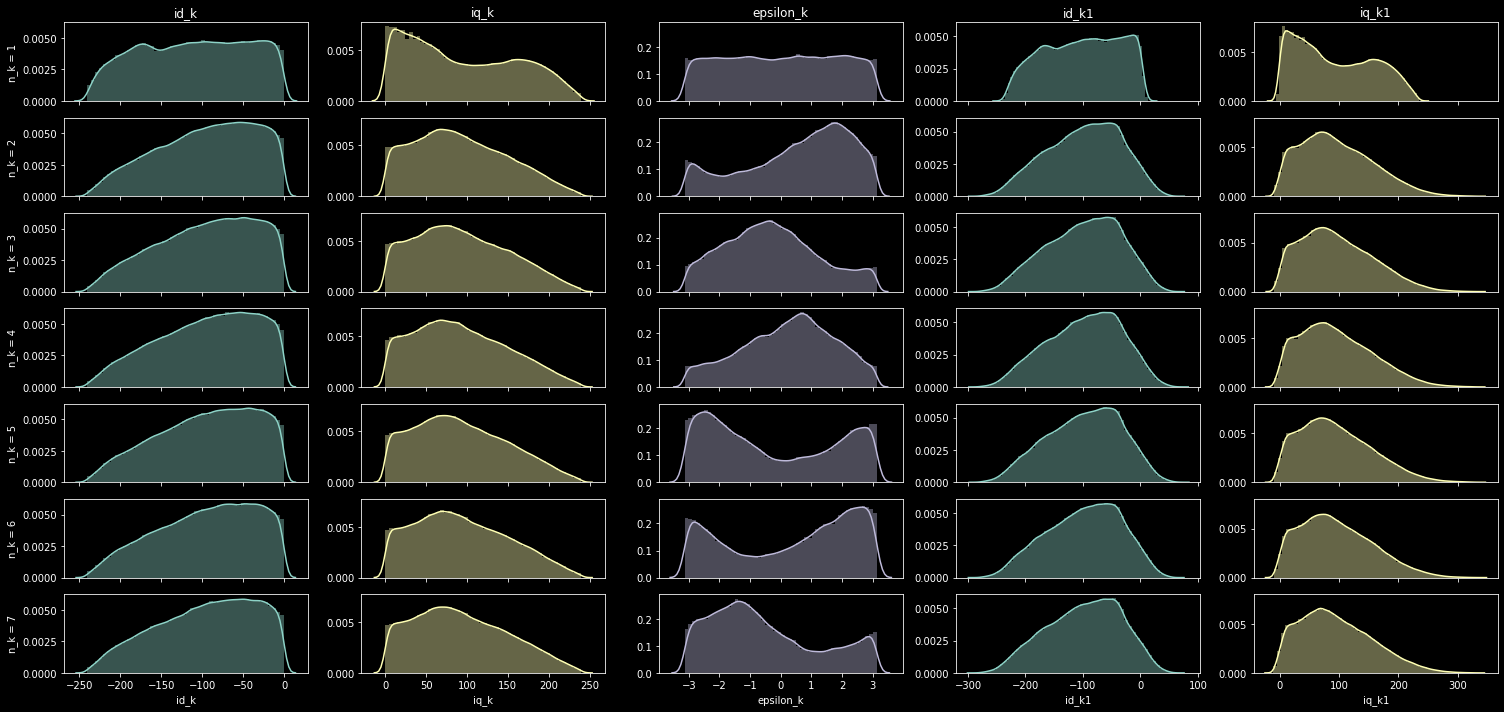

In [8]:
analyzed_cols = [c for c in df if c not in ['n_k', 'n_1k', 'pairs']]

# prepare colors
color_list = plt.cm.Set3(np.linspace(0, 1, 12))
color_d = {'id_k': rgb2hex(color_list[0]),
           'id_k1': rgb2hex(color_list[0]),
           'iq_k': rgb2hex(color_list[1]),
           'iq_k1': rgb2hex(color_list[1]),
           'epsilon_k': rgb2hex(color_list[2])}

def dist_plot(dframe, cols_to_plot):
    unique_elem_vecs = dframe['n_k'].nunique()
    # create plot
    fig, axes = plt.subplots(nrows=unique_elem_vecs, ncols=len(cols_to_plot), 
                             sharex='col', sharey='col', figsize=(3*unique_elem_vecs, 10))
    for k, _df in dframe.groupby('n_k'):
        for i, c in enumerate(cols_to_plot):
            sns.distplot(_df[c], ax=axes[k-1, i], color=color_d.get(c, None))
            if i == 0:
                axes[k-1, i].set_ylabel(f'n_k = {k}')
            if k == 1:
                axes[k-1, i].set_title(c)
            xlbl = c if k == 7 else ''
            axes[k-1, i].set_xlabel(xlbl)

    plt.tight_layout()
dist_plot(df, analyzed_cols)

_(Double-click picture if it appears too small)_.

It seems that _epsilon_k_ exhibits a sine shaped histogram while its range covers $[-\pi, \pi]$.

More subtle, we recognize a semi-sphere shape of the 2d histogram between the currents (remember, d and q currents are to be plotted perpendicular to each other).
It might be auspicious, to add another feature denoting the current vector norm sqrt(id^2 + iq^2).
From the principle of d/q-transformation, we know that the $\ell_2$-norm of the d- and q-current denotes the current amplitude in the system.
From that we recognize, that smaller current magnitudes seem more likely than higher.

#### Task 1: Add features and plot their distributions
* Add sine and cosine of the rotor angle to the dataframe
* Add the current vector norm of both time steps to the dataframe: $i_{norm} = \sqrt{i_d^2 + i_q^2}$
* Plot their distributions

#### Solution 1

In [9]:
df = df.assign(sin_eps_k=lambda df: np.sin(df.epsilon_k), 
               cos_eps_k=lambda df: np.cos(df.epsilon_k),
               i_norm_k=lambda df: np.sqrt(df.id_k**2 + df.iq_k**2),
               i_norm_k1=lambda df: np.sqrt(df.id_k1**2 + df.iq_k1**2))
df.head()

,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1,pairs,sin_eps_k,cos_eps_k,i_norm_k,i_norm_k1
0,-63.43288,222.963500,-1.624982,1,1,-52.36959,217.568600,1->1,-0.998532,-0.054159,231.811243,223.782639
1,-138.64790,164.999000,-0.499233,1,1,-126.95130,163.001400,1->1,-0.478753,0.877950,215.517772,206.606120
2,-162.46010,38.855290,-2.065194,1,1,-156.43410,38.598410,1->1,-0.880255,-0.474502,167.041964,161.125618
3,-219.68470,0.211794,-2.266253,1,1,-218.79350,0.402872,1->1,-0.767761,-0.640736,219.684802,218.793871
4,-86.63434,160.142600,-3.091227,1,1,-75.96732,157.305300,1->1,-0.050344,-0.998732,182.074603,174.688268


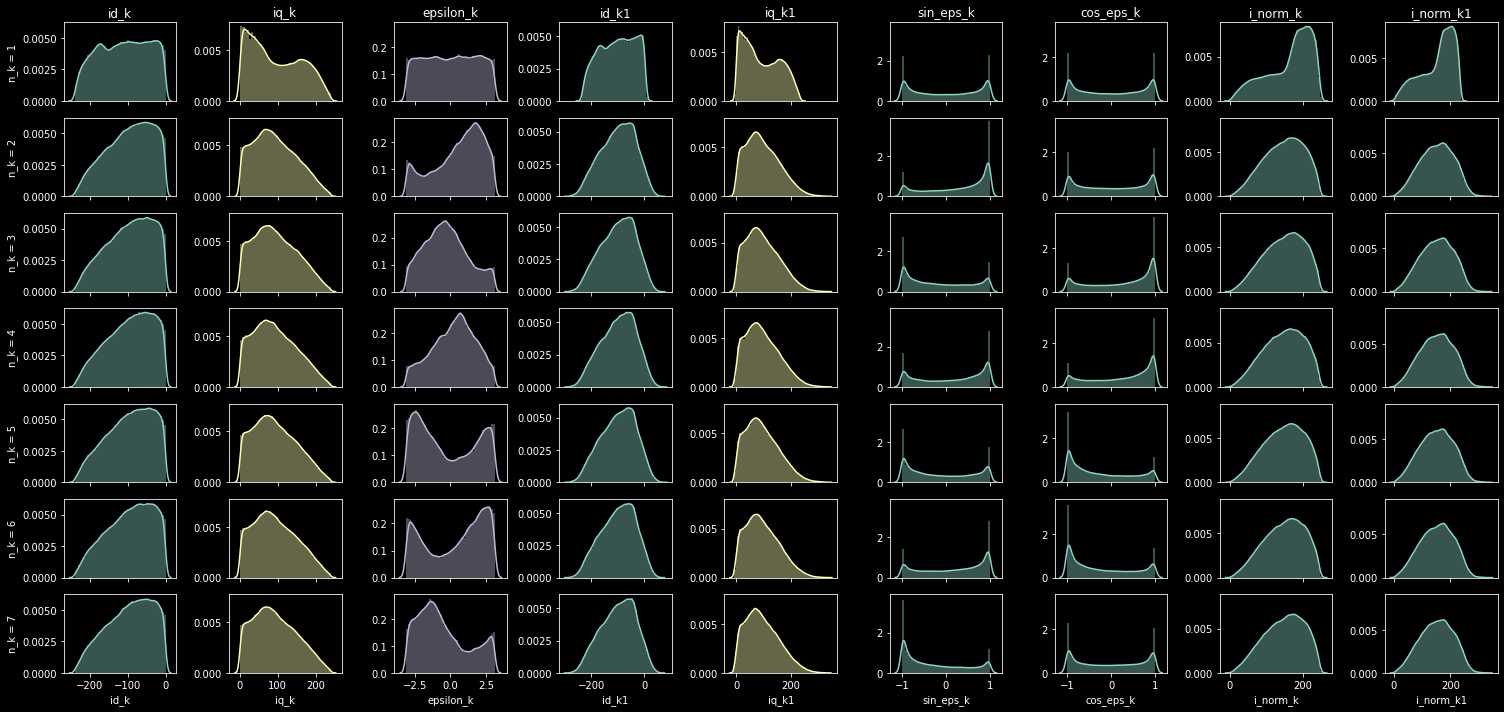

In [10]:
dist_plot(df, [c for c in df if c not in ['n_k', 'n_1k', 'pairs']])

### Scatter plots
Probably, the previous currents are good indicators for the next currents.
Let's visualize this relationship unfold over each transition.

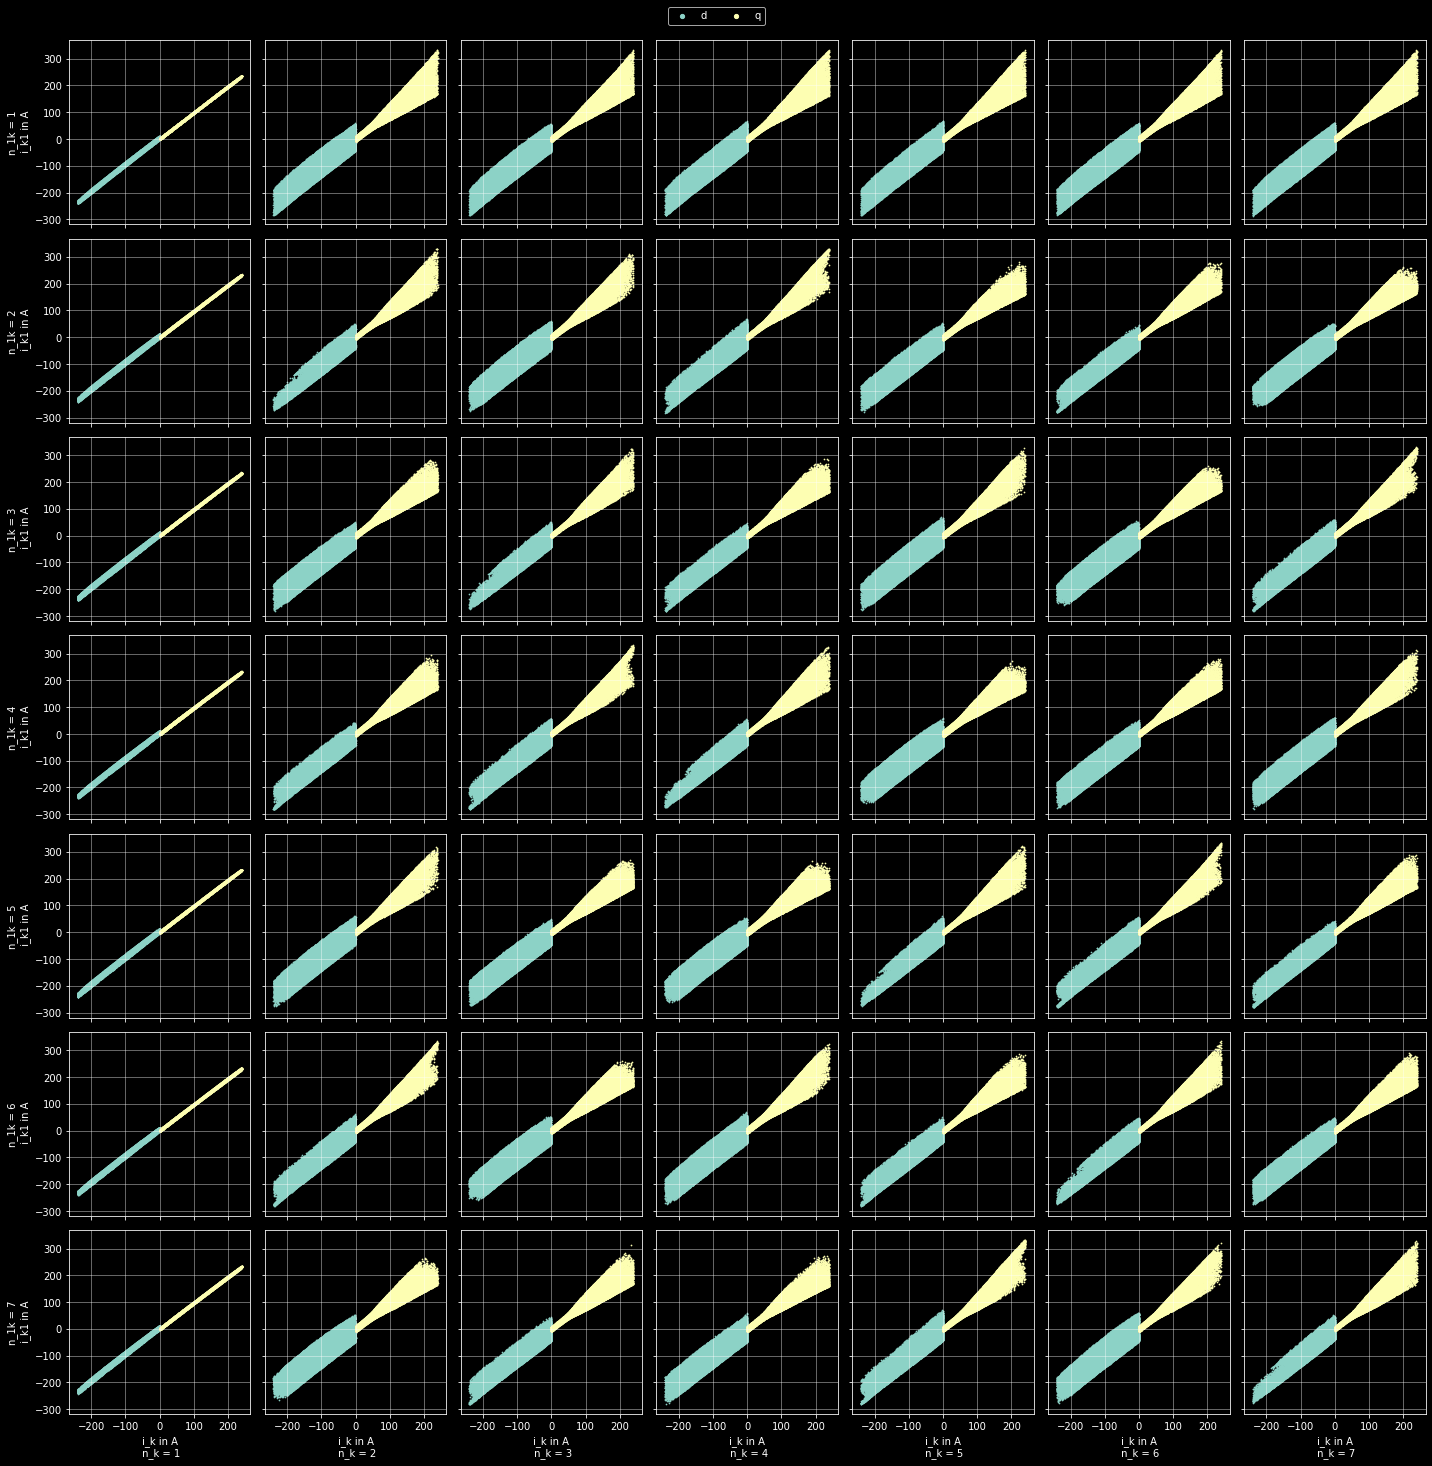

In [11]:
n_cols = 7
n_rows = 7
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, 
                         sharex=True, sharey=True, figsize=(20, 20))
df = df.sort_values(by='pairs')
for ax, (k, _df) in zip(axes.flatten(), df.groupby('pairs')):
    t_prev, t = k.split('->')
    ax.scatter(_df.id_k, _df.id_k1, s=.5, label='d')
    ax.scatter(_df.iq_k, _df.iq_k1, s=.5, label='q')
    if t == '1':
        ax.set_ylabel(f'n_1k = {t_prev}\n i_k1 in A')
    if t_prev == '7':
        ax.set_xlabel(f'i_k in A\n n_k = {t}')
    ax.grid(alpha=.5)
plt.tight_layout()

ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure, markerscale=6)

Apparently, transitions to switching_state == 1 come with far less scatter than for other switching states.
Beyond this, the overall scatter seems relatively linear.

We investigate this by a linear correlation heat map.

### Linear Correlation
The [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) indicates the strength of the linear correlation between two random variables.

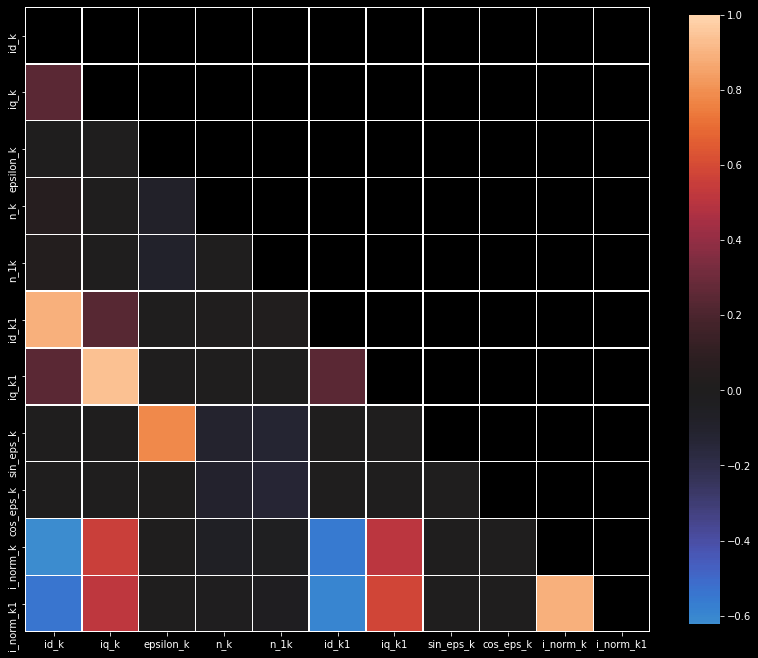

In [12]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(14,14))
_ = sns.heatmap(corr, mask=mask, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8})

It becomes obvious, that features from previous time steps exhibit the strongest linear correlation with those of the actual time step.

This suggests a strong timely dependency, currents follow a [non-stationary process](https://en.wikipedia.org/wiki/Stationary_process).

It is very likely, that more history information for each point in time would reveal precious patterns for an exact forecast of the currents, but these are not available here.

__Bonus task__ : Can you reconstruct measurement sessions from the shuffled dataset by comparison of samples? Use the original data set for this.

## Cross Validation

Before we start modeling, we need to agree on a certain cross-validation (CV) technique.
We will choose a method from scikit-learn.

Please install it with
```
pip install scikit-learn
```

Since distribution of elementary vectors is rather balanced, we will go with a simple CV: 5-Fold CV.

Recall from the lecture what K-Fold CV stands for.

![](kfold-cv.png)

In [13]:
from sklearn.model_selection import KFold

In [14]:
kf = KFold(n_splits=5, shuffle=True)

## Regression
We start off with a regression example: Given the data set, predict the future currents at any time.

### Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse


# more feature engineering
enriched_df = df.assign(id_k_sqrd=lambda x: x.id_k**2,
                        iq_k_sqrd=lambda x: x.iq_k**2,
                        iq_x_id_k=lambda x: x.id_k*x.iq_k,
                        i_norm_sqrd=lambda x: x.i_norm_k**2,
                        id_k_log=lambda x: np.log1p(x.id_k.abs()),
                        iq_k_log=lambda x: np.log1p(x.iq_k),
                        id_k_exp=lambda x: np.exp(-x.id_k.abs()),
                        iq_k_exp=lambda x: np.exp(-x.iq_k.abs()),
                        i_norm_log=lambda x: np.log1p(x.i_norm_k),
                        i_norm_exp=lambda x: np.exp(x.i_norm_k.abs()),
                        id_plus_iq=lambda x: x.id_k+x.iq_k,
                        id_minus_iq=lambda x: x.id_k-x.iq_k,
                        id_over_iq=lambda x: x.id_k/ (x.iq_k + 1),
                        iq_over_id=lambda x: x.iq_k/ (x.id_k - 1),
                        # the following features encompass the whole data set. Is this problematic?
                        id_pairgroup_normed=lambda x: x.id_k - df.groupby('pairs')['id_k'].transform('mean'),
                        iq_pairgroup_normed=lambda x: x.iq_k - df.groupby('pairs')['iq_k'].transform('mean'),
                        id_ngroup_normed=lambda x: x.id_k - df.groupby('n_k')['id_k'].transform('mean'),
                        iq_ngroup_normed=lambda x: x.iq_k - df.groupby('n_k')['iq_k'].transform('mean'),
                      )

y_cols = ['id_k1', 'iq_k1', 'i_norm_k1']
x_cols = [c for c in enriched_df if c not in y_cols + ['pairs'] ]

for i, (train_index, test_index) in enumerate(kf.split(enriched_df)):
    x_train, y_train = enriched_df.loc[train_index, x_cols], enriched_df.loc[train_index, y_cols]
    x_test, y_test = enriched_df.loc[test_index, x_cols], enriched_df.loc[test_index, y_cols].values
    
    # feature aggregations over the training set
    model = LinearRegression()

    model.fit(x_train, y_train)
    prediction = model.predict(x_test)

    result_string = ', '.join(f'{y_cols[j]}: {mse(y_test[:, j], prediction[:, j]):.2f} A²' for j in range(len(y_cols)))
    print(f'Fold {i}: \nMSE:\t', result_string)

Fold 0: 
MSE:	 id_k1: 4115.16 A², iq_k1: 3704.52 A², i_norm_k1: 3337.89 A²
Fold 1: 
MSE:	 id_k1: 4123.71 A², iq_k1: 3710.08 A², i_norm_k1: 3349.07 A²
Fold 2: 
MSE:	 id_k1: 4098.39 A², iq_k1: 3710.31 A², i_norm_k1: 3341.37 A²
Fold 3: 
MSE:	 id_k1: 4119.44 A², iq_k1: 3706.04 A², i_norm_k1: 3337.59 A²
Fold 4: 
MSE:	 id_k1: 4123.70 A², iq_k1: 3718.04 A², i_norm_k1: 3342.89 A²


The error is homogenous across folds, which affirms our CV strategy.

However, the estimation error is fairly large.

#### Task 2: What did we miss to do before fitting the linear model?
Two important preprocessing steps were missed before conducting model training.
Which might they be? It has something to do with categorical values and value ranges.

In the following, rectify this blunder, and prepare the data appropriately.
* Conduct the CV again.
* Plot the estimation error of the last fold over the corresponding ground truth.

Can you think of more features? Do you think there might be a problem with those features that were aggregated over the full data set in the beginning?

#### Solution 2:

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# one-hot-encode categoricals
ohe_df = enriched_df.assign(**{**{f'n_k_{i}': (enriched_df.n_k == i).astype(int) for i in range(1, 8)},
                               **{f'n_1k_{i}': (enriched_df.n_1k == i).astype(int) for i in range(1, 8)}})\
                        .drop(['n_k', 'n_1k', 'pairs'], axis=1)



y_cols = ['id_k1', 'iq_k1', 'i_norm_k1']
x_cols = [c for c in ohe_df if c not in y_cols]


x_cols_to_scale = [c for c in x_cols if not c.startswith(('n_k', 'n_1k'))]

for i, (train_index, test_index) in enumerate(kf.split(ohe_df)):
        train_set = ohe_df.loc[train_index, :]
        test_set = ohe_df.loc[test_index, :]
        
        # scale
        x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
        x_train = train_set.loc[:, x_cols]
        x_train.loc[:, x_cols_to_scale] = x_scaler.fit_transform(x_train.loc[:, x_cols_to_scale])
        y_train = y_scaler.fit_transform(train_set.loc[:, y_cols])
        x_test = test_set.loc[:, x_cols]
        x_test.loc[:, x_cols_to_scale] = x_scaler.transform(x_test.loc[:, x_cols_to_scale])
        y_test = test_set.loc[:, y_cols].values
        
        # validate
        model = LinearRegression()
        model.fit(x_train, y_train)
        prediction = model.predict(x_test)
        prediction = y_scaler.inverse_transform(prediction)
        
        result_string = ', '.join(f'{y_cols[j]}: {mse(y_test[:, j], prediction[:, j]):.2f} A²' 
                                  for j in range(len(y_cols)))
        print(f'Fold {i}: \nMSE:\t', result_string)



Fold 0: 
MSE:	 id_k1: 734.46 A², iq_k1: 393.92 A², i_norm_k1: 634.96 A²
Fold 1: 
MSE:	 id_k1: 734.89 A², iq_k1: 393.92 A², i_norm_k1: 633.71 A²
Fold 2: 
MSE:	 id_k1: 734.15 A², iq_k1: 394.27 A², i_norm_k1: 633.85 A²
Fold 3: 
MSE:	 id_k1: 735.50 A², iq_k1: 392.52 A², i_norm_k1: 631.83 A²
Fold 4: 
MSE:	 id_k1: 733.76 A², iq_k1: 394.69 A², i_norm_k1: 634.47 A²


### Residuals

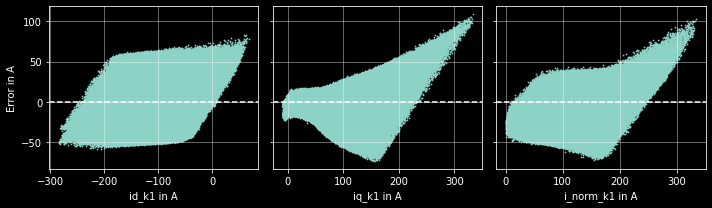

In [17]:
# residuals
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey='row')
error = y_test - prediction

for i in range(len(y_cols)):
    axes[i].scatter(y_test[:, i], error[:, i], s=.5, label=y_cols[i])
    axes[i].grid(alpha=.5)
    axes[i].axhline(ls='--')
    if i == 0:
        axes[i].set_ylabel('Error in A')
    axes[i].set_xlabel(y_cols[i]+' in A')
fig.tight_layout()

The residuals show strong geometrical shapes along the ground truth. Hence, systematic errors are still included.

## Neural Networks
In the following, a neural network class is given, which can be used the very same way as the scikit-learn linear model.

For the imports to work, please install tensorflow 2:

```
pip install tensorflow
```


In [1]:
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers as opts
from tensorflow.keras import layers, regularizers, initializers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_mlp_model(x_shape=(100, 1, 10),  # input shape to the NN
                  n_layers=1,  # number of hidden layers
                  n_units=64,  # number of neurons per hidden layer
                  kernel_reg=1e-9,  # kernel regularization strength
                  activity_reg=1e-9,  # activity regularization strength
                  bias_reg=1e-9,  # bias regularization strength
                  activation='relu',  # activation function
                  lr_rate=1e-5,  # learning rate (step size)
                  loss='mse',  # cost function for training (here, MSE)
                  n_targets=1,  # number of neurons in output layer
                  seed=None, print_summary=True):
    """build mlp model"""

    cfg = {
        'units': int(n_units),
        'kernel_regularizer': regularizers.l2(kernel_reg),
        'activity_regularizer': regularizers.l2(activity_reg),
        'bias_regularizer': regularizers.l2(bias_reg),
        'kernel_initializer': initializers.lecun_normal(seed=seed),
        'activation': activation,
    }
    
    # keras functional API
    x = layers.Input(shape=x_shape)  # Input layer
    y = layers.Dense(**cfg)(x)  # Hidden layer (feed-forward)
    if n_layers > 1:
        for i in range(n_layers-1):
            y = layers.Dense(**cfg)(y)   # Hidden layer (feed-forward)
    y = layers.Dense(n_targets)(y)  # Output layer (feed-forward)

    model = Model(inputs=x, outputs=y)
    model.compile(optimizer=opts.Adam(lr=lr_rate), loss=loss)
    if print_summary:
        model.summary()
    return model

class MLP(KerasRegressor):
    """Multi-Layer Perceptron with Scikit-learn API"""
    
    def __init__(self, len_x_cols, len_y_cols, print_summary=True):
        # Hard coded build function and kwargs
        KerasRegressor_config = {'batch_size': 128,  # how many samples per batch
                               'epochs': 99,  # amount of iterations over the data set
                               'activation': 'relu',  # activation function
                               'n_layers': 1,  # no. hidden layers
                               'n_units': 32,  # no. hidden units/neurons
                               'kernel_reg': 1e-9,  # kernel l2 regularization strength
                               'activity_reg': 1e-9,  # activity l2 regularization strength
                               'bias_reg': 1e-9,  # bias l2 regularization strength
                               'lr_rate': 5e-4,  # learn rate
                               'n_targets': len_y_cols,  # no. targets
                               'loss': 'mse',  # loss function
                               'verbose': 1,  # verbosity
                               'x_shape': (len_x_cols,),  # input shape into NN
                               'print_summary': print_summary
                               }
        super().__init__(build_fn=build_mlp_model, **KerasRegressor_config)

    def fit(self, X, y, **kwargs):
        
        # Neural Network training encompasses validation against another validation 
        #  set (next to those of kfold CV), on which overfitting is monitored per epoch
        if kwargs.get('validation_data', None) is None:
            # determine validation set dynamically
            val_ratio = 0.1  # 10% validation data
            if isinstance(X, pd.DataFrame): X = X.values
            if isinstance(y, pd.DataFrame): y = y.values
            n_val_set = int(val_ratio * len(X))
            X, X_val = X[:-n_val_set, :], X[-n_val_set:, :]
            if len(y.shape) == 1:
                y = y[:, np.newaxis]
            y, y_val = y[:-n_val_set, :], y[-n_val_set:, :]
            kwargs['validation_data'] = (X_val, y_val)
        
        # Add learn scheduling
        #  Early stopping: Stop training if validation error plateaus
        #  ReduceLrOnPlateau: If loss on train set plateaus, reduce learn rate
        kwargs['callbacks'] = [EarlyStopping(monitor='val_loss',
                                              min_delta=1e-3,
                                              patience=10,
                                              verbose=1),
                                ReduceLROnPlateau(monitor='loss',
                                                  patience=5,
                                                  factor=0.5), ]
        kwargs['epochs'] = 20
        kwargs['batch_size'] = 64
        ret = super().fit(X, y, **kwargs)

        return ret

#### Task 3: Conduct CV under the same regression task as above.
Is a neural network better?

Be aware that training time of a neural network is substantially longer than for linear models. If you face out-of-memory errors, please reduce the n_units parameter, the batch_size parameter, or subsample the data set.

Bonus task: Try to tweak the hyperparameters of the NN in order to achieve a better performance.

If you find a decent setting, you are invited to post your solution to [kaggle kernels](https://www.kaggle.com/hankelea/system-identification-of-an-electric-motor/kernels). Don't be shy!

#### Solution 3:


In [19]:
for i, (train_index, test_index) in enumerate(kf.split(ohe_df)):
        train_set = ohe_df.loc[train_index, :]
        test_set = ohe_df.loc[test_index, :]
        
        # scale
        x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
        x_train = train_set.loc[:, x_cols]
        x_train.loc[:, x_cols_to_scale] = x_scaler.fit_transform(x_train.loc[:, x_cols_to_scale])
        y_train = y_scaler.fit_transform(train_set.loc[:, y_cols])
        x_test = test_set.loc[:, x_cols]
        x_test.loc[:, x_cols_to_scale] = x_scaler.transform(x_test.loc[:, x_cols_to_scale])
        y_test = test_set.loc[:, y_cols].values
        
        # validate
        model = MLP(len(x_cols), len(y_cols), print_summary=i==0)
        model.fit(x_train, y_train)
        prediction = model.predict(x_test)
        prediction = y_scaler.inverse_transform(prediction)
        
        result_string = ', '.join(f'{y_cols[j]}: {mse(y_test[:, j], prediction[:, j]):.2f} A²' 
                                  for j in range(len(y_cols)))
        print(f'Fold {i}: \nMSE:\t', result_string)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 38)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1248      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,347
Trainable params: 1,347
Non-trainable params: 0
_________________________________________________________________
Train on 1764000 samples, validate on 196000 samples
Epoch 1/20
1764000/1764000 [==============================] - 19s 11us/sample - loss: 0.0050 - val_loss: 0.0078
Epoch 2/20
1764000/1764000 [==============================] - 22s 13us/sample - loss: 0.0045 - val_loss: 0.0026
Epoch 3/20
1764000/1764000 [==============================] - 21s 12us/sample - loss: 0.0045 - val_loss: 0.0039


Epoch 4/20
1764000/1764000 [==============================] - 20s 11us/sample - loss: 0.0043 - val_loss: 0.0032
Epoch 5/20
1764000/1764000 [==============================] - 19s 11us/sample - loss: 0.0042 - val_loss: 0.0120
Epoch 6/20
1764000/1764000 [==============================] - 20s 12us/sample - loss: 0.0042 - val_loss: 0.0146
Epoch 7/20
1764000/1764000 [==============================] - 20s 11us/sample - loss: 0.0042 - val_loss: 0.0156
Epoch 8/20
1764000/1764000 [==============================] - 19s 11us/sample - loss: 0.0041 - val_loss: 0.0155
Epoch 9/20
1764000/1764000 [==============================] - 20s 11us/sample - loss: 0.0041 - val_loss: 0.0104
Epoch 10/20
1764000/1764000 [==============================] - 21s 12us/sample - loss: 0.0041 - val_loss: 0.0100
Epoch 11/20
1764000/1764000 [==============================] - 20s 11us/sample - loss: 0.0041 - val_loss: 0.0112
Epoch 12/20
1764000/1764000 [==============================] - 19s 11us/sample - loss: 0.0041 - val_lo

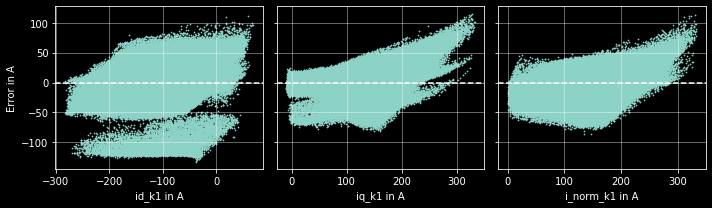

In [20]:
# residuals
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey='row')
error = y_test - prediction

for i in range(len(y_cols)):
    axes[i].scatter(y_test[:, i], error[:, i], s=.5, label=y_cols[i])
    axes[i].grid(alpha=.5)
    axes[i].axhline(ls='--')
    if i == 0:
        axes[i].set_ylabel('Error in A')
    axes[i].set_xlabel(y_cols[i]+' in A')
fig.tight_layout()

## Classification
We swap the task from regression to classification by predicting __n_k__ given all other features including currents at time k+1.

We start off with [logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) (which is a classifying model despite its name).

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss  # cross-entropy error
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# instantiate a logistic regression model with the following arguments for faster training
LogisticRegression(solver='sag', multi_class='multinomial', max_iter=30, n_jobs=-1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=30,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

#### Task 4: Conduct CV with LogisticRegression under a classification task
* Predict __n_k__ - all other features are allowed as input features.
Use the [cross-entropy loss](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss) as metric.
* Print the corresponding [confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) of the last fold's prediction

Tip: We need to restore the original n_k feature but keep n_1k one-hot-encoded in order to use it as input feature.

#### Solution 4


In [36]:
classify_df = ohe_df.drop([c for c in ohe_df if c.startswith('n_k')], axis=1).assign(n_k=enriched_df.n_k)

y_cols = 'n_k'
x_cols = [c for c in classify_df if c != y_cols]

print('start cv..')
for i, (train_index, test_index) in enumerate(kf.split(classify_df)):
        train_set = classify_df.loc[train_index, :]
        test_set = classify_df.loc[test_index, :]
        
        # scale (here, only x features, since target is multi-class)
        x_scaler = MinMaxScaler()
        x_train = train_set.loc[:, x_cols]
        x_train.loc[:, x_cols_to_scale] = x_scaler.fit_transform(x_train.loc[:, x_cols_to_scale])
        y_train = train_set.loc[:, y_cols]
        x_test = test_set.loc[:, x_cols]
        x_test.loc[:, x_cols_to_scale] = x_scaler.transform(x_test.loc[:, x_cols_to_scale])
        y_test = test_set.loc[:, y_cols].values
        
        # validate
        model = LogisticRegression(solver='sag', multi_class='multinomial', max_iter=30, n_jobs=-1).fit(x_train, y_train)
        prediction = model.predict_proba(x_test)
        
        result_string = f'{y_cols}: {log_loss(y_test, prediction):.2f}'
        print(f'Fold {i}: \nCE:\t', result_string)

start cv..
Fold 0: 
CE:	 n_k: 1.79
Fold 1: 
CE:	 n_k: 1.79
Fold 2: 
CE:	 n_k: 1.79
Fold 3: 
CE:	 n_k: 1.79
Fold 4: 
CE:	 n_k: 1.79


In [42]:
cm = pd.DataFrame(confusion_matrix(y_test, np.argmax(prediction, axis=1)+1),
             columns=range(1,8)).assign(Ground_Truth=range(1,8)).set_index('Ground_Truth')
cm.columns.name = 'Prediction'
cm

Prediction,1,2,3,4,5,6,7
Ground_Truth,,,,,,,
1,44892,4033,4183,4134,3851,4165,4821
2,8036,20002,6365,12589,6409,12560,4203
3,7861,6027,18314,14146,7251,3482,12987
4,7712,14765,12383,18444,4173,5674,6975
5,7749,5347,6277,4361,17739,13503,14573
6,8427,11958,3355,7093,12501,19994,6563
7,8331,3151,13911,7098,13544,5927,18161


### Gradient Boosting Machines

For the classification with GBMs we will utilize [Microsoft's lightGBM](https://lightgbm.readthedocs.io/en/latest/index.html), which comes with a scikit-learn estimator interface:

```
pip install lightgbm
```

In [45]:
from lightgbm import LGBMClassifier


# initialize like the following
LGBMClassifier(objective='multiclass', n_jobs=-1, n_estimators=30)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=30, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

#### Task 5: Use a GBM to classify n_k

Recall, that for a decision-tree-based model, normalization is optional.

#### Solution 5:

In [43]:
classify_df = df.drop(['pairs'], axis=1)

y_cols = 'n_k'
x_cols = [c for c in classify_df if c != y_cols]

print('start cv..')
for i, (train_index, test_index) in enumerate(kf.split(classify_df)):
       
        x_train = classify_df.loc[train_index, x_cols]
        y_train = classify_df.loc[train_index, y_cols]
        x_test = classify_df.loc[test_index, x_cols]
        y_test = classify_df.loc[test_index, y_cols].values
        
        # validate
        model = LGBMClassifier(objective='multiclass', n_jobs=-1, n_estimators=100).fit(x_train, y_train)
        prediction = model.predict_proba(x_test)
        
        result_string = f'{y_cols}: {log_loss(y_test, prediction):.2f}'
        print(f'Fold {i}: \nCE:\t', result_string)

start cv..
Fold 0: 
CE:	 n_k: 0.67
Fold 1: 
CE:	 n_k: 0.67
Fold 2: 
CE:	 n_k: 0.64
Fold 3: 
CE:	 n_k: 0.65
Fold 4: 
CE:	 n_k: 0.66


In [44]:
cm = pd.DataFrame(confusion_matrix(y_test, np.argmax(prediction, axis=1)+1),
             columns=range(1,8)).assign(Ground_Truth=range(1,8)).set_index('Ground_Truth')
cm.columns.name = 'Prediction'
cm

Prediction,1,2,3,4,5,6,7
Ground_Truth,,,,,,,
1,69923,8,12,3,9,7,2
2,1261,60985,377,3890,2,3633,99
3,1694,37,59437,2350,40,51,6462
4,872,309,2472,66026,0,0,256
5,1115,142,41,9,66875,1077,411
6,1008,4451,62,29,1268,63139,2
7,2015,67,3152,29,3368,165,61358


Note in particular, runtime and precision differences between GBMs and logistic regression, as well as in resource utilization.